In [4]:
import pandas as pd
import json
import os
from shapely.geometry import LineString, box
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from io import BytesIO
from shapely.geometry import LineString, box
from datetime import datetime

In [5]:
# def process_csv_to_excel(csv_file, excel_file):
#     """
#     Reads the CSV file, processes the data to group coordinates by individual ID, 
#     and writes the results to an Excel file with columns 'id', 'date', and 'POLYLINE'.
#     Rows without coordinates are ignored.
#     """
#     # Load the CSV file into a pandas DataFrame
#     df = pd.read_csv(csv_file)
    
#     # Create an empty dictionary to store the results by ID
#     data_by_id = {}

#     # Iterate through each row in the dataframe
#     for index, row in df.iterrows():
#         # Skip rows without coordinates (location-long or location-lat missing)
#         if pd.isnull(row['location-long']) or pd.isnull(row['location-lat']):
#             continue
        
#         # Extract relevant data
#         individual_id = row['individual-local-identifier']
#         timestamp = row['timestamp']
#         coordinates = [row['location-long'], row['location-lat']]

#         # If the ID is not already in the dictionary, initialize it with an empty list
#         if individual_id not in data_by_id:
#             data_by_id[individual_id] = {'date': timestamp, 'polyline': []}
        
#         # Append the coordinate to the polyline list for the corresponding ID
#         data_by_id[individual_id]['polyline'].append(coordinates)
    
#     # Prepare data for the Excel file
#     excel_data = []
#     for individual_id, data in data_by_id.items():
#         # Create the row for the Excel file
#         row = {
#             'id': individual_id,
#             'date': data['date'],
#             'POLYLINE': json.dumps(data['polyline'])
#         }
#         excel_data.append(row)
    
#     # Convert the data into a DataFrame
#     excel_df = pd.DataFrame(excel_data)

#     # Write the data to an Excel file
#     excel_df.to_excel(excel_file, index=False)
#     print(f"Data successfully written to {excel_file}")

In [6]:
def process_csv_to_excel(csv_file, excel_file):
    """
    Reads the CSV file, processes the data to group coordinates by individual ID and date,
    and writes the results to an Excel file with columns 'id', 'date', and 'POLYLINE'.
    Rows without coordinates are ignored.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Create an empty dictionary to store the results by ID and date
    data_by_id_and_date = {}

    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Skip rows without coordinates (location-long or location-lat missing)
        if pd.isnull(row['location-long']) or pd.isnull(row['location-lat']):
            continue
        
        # Extract relevant data
        individual_id = row['individual-local-identifier']
        timestamp = row['timestamp']
        date = timestamp.split(' ')[0]  # Extract the date (ignore the time part)
        coordinates = [row['location-long'], row['location-lat']]

        # Initialize a dictionary for the individual if it doesn't exist
        if individual_id not in data_by_id_and_date:
            data_by_id_and_date[individual_id] = {}

        # Initialize a list for the specific date if it doesn't exist
        if date not in data_by_id_and_date[individual_id]:
            data_by_id_and_date[individual_id][date] = {'polyline': []}

        # Append the coordinates to the polyline list for the corresponding ID and date
        data_by_id_and_date[individual_id][date]['polyline'].append(coordinates)
    
    # Prepare data for the Excel file
    excel_data = []
    for individual_id, dates in data_by_id_and_date.items():
        for date, data in dates.items():
            # Create a row for the Excel file
            row = {
                'id': individual_id,
                'date': date,
                'POLYLINE': json.dumps(data['polyline'])
            }
            excel_data.append(row)
    
    # Convert the data into a DataFrame
    excel_df = pd.DataFrame(excel_data)

    # Write the data to an Excel file
    excel_df.to_excel(excel_file, index=False)
    print(f"Data successfully written to {excel_file}")

In [7]:
def load_and_simplify_data(filepath, rows, tolerance=0.001):
    """
    Loads and simplifies data from a file, either CSV or Excel, and prepares it for processing.

    Parameters:
    - filename: str, the uploaded file containing trajectory data.
    - rows: int, the maximum number of rows to load.
    - tolerance: float, the tolerance value used to simplify geometries.

    Returns:
    - gdf: GeoDataFrame, geospatial data with simplified geometries.
    - trayectorias: list, a list of numpy arrays representing trajectories.
    - df: DataFrame, original data with converted geometries and filtered rows.
    """
    try:
        # Decode the base64-encoded file content
        # _, content_string = filename.split(',')
        # decoded = base64.b64decode(content_string)

        # Load data as DataFrame based on file type
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath, nrows=rows)
        elif filepath.endswith('.xlsx'):
            df = pd.read_excel(filepath, nrows=rows)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

        print(df)


        # Convert the POLYLINE column to geometries
        def create_line(x):
            points = json.loads(x)
            if len(points) > 1:
                return LineString(points)
            return None

        # Apply geometry transformation and filter invalid rows
        df['geometry'] = df['POLYLINE'].apply(create_line)
        df = df[df['geometry'].notnull()]
        gdf = gpd.GeoDataFrame(df, geometry='geometry')

        # Simplify geometries based on the tolerance value
        gdf['geometry'] = gdf['geometry'].simplify(tolerance)

        # Convert POLYLINE JSON strings to lists and filter invalid entries
        df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)
        df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

        # Prepare trajectories for TRACLUS processing
        trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

        return gdf, trayectorias, df

    except Exception as e:
        # Handle errors in data loading
        print(f"Error loading and simplifying data: {e}")
        raise e

In [16]:
def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    """
    Filter GeoDataFrame to include geometries within a specified area.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame.
        minx, miny, maxx, maxy (float): Coordinates defining the area.

    Returns:
        GeoDataFrame: Filtered GeoDataFrame.
    """
    area_of_interest = box(minx, miny, maxx, maxy)
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    return gdf_filtered

def list_coordinates(gdf):
    """
    Extract x and y coordinates from a GeoDataFrame's LineString geometries.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame containing LineString geometries.

    Returns:
        tuple: Two lists containing x and y coordinates respectively.
    """
    x_coords_flat = []
    y_coords_flat = []

    for geom in gdf['geometry']:
        if isinstance(geom, LineString):
            for point in geom.coords:
                x_coords_flat.append(point[0])
                y_coords_flat.append(point[1])

    return x_coords_flat, y_coords_flat

def get_coordinates(gdf):
    """
    Get the minimum and maximum x and y coordinates from a GeoDataFrame.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame containing geometry.

    Returns:
        tuple: (minx, miny, maxx, maxy) - minimum and maximum coordinates.
    """
    x_coords_flat, y_coords_flat = list_coordinates(gdf)
    maxx, maxy, minx, miny = max(x_coords_flat), max(y_coords_flat), min(x_coords_flat), min(y_coords_flat)
    return minx, miny, maxx, maxy

def map_ilustration(gdf, minx, miny, maxx, maxy):
    """
    Create a map with trajectories overlaid on a base map.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame with trajectories.
        minx, miny, maxx, maxy (float): Coordinates for filtering data.

    Returns:
        BytesIO: Image data of the generated map.
    """
    gdf = gdf.set_crs("EPSG:4326")
    gdf = filter_data_in_area(gdf, minx, miny, maxx, maxy)
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    gdf.plot(ax=ax, linewidth=0.5, color='green')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    plt.title('Map of Trajectories with Background Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    plt.close(fig)  

In [17]:
# input_file = r"C:\Users\Álvaro\Documents\GitHub\TFG\TFG_TRACLUS\code\Research and experiments\Data transformer\data_to_analyze\movebank.csv"
# output_file = "MoveBank.xlsx" 

# process_csv_to_excel(input_file, output_file)

In [18]:
file = r"C:\Users\Álvaro\Documents\GitHub\TFG\TFG_TRACLUS\code\Research and experiments\Data transformer\transformed_data\MoveBank.xlsx"

gdf, tray, df = load_and_simplify_data(file, rows=10000)

        id        date                                           POLYLINE
0     7455  2020-01-12  [[14.1809706, 0.2031892], [14.1811807, 0.20297...
1     7455  2020-01-13  [[14.1810847, 0.2030828], [14.1817625, 0.20277...
2    7455b  2020-01-16  [[14.2142854, 0.2507652], [14.2139215, 0.25000...
3    7455b  2020-01-17  [[14.1780045, 0.2107595], [14.1780985, 0.21068...
4    7455b  2020-01-18  [[14.1780321, 0.2107908], [14.1781301, 0.21044...
..     ...         ...                                                ...
367   7475  2020-01-26  [[14.1040989, 0.1284948], [14.1060274, 0.13270...
368   7475  2020-01-27  [[14.1184946, 0.1414535], [14.1184624, 0.14156...
369   7475  2020-01-28  [[14.1192121, 0.1410515], [14.1193117, 0.14109...
370   7475  2020-01-29  [[14.1170314, 0.1391737], [14.117873, 0.140741...
371   7475  2020-01-30  [[14.1120104, 0.1343825], [14.1179057, 0.14026...

[372 rows x 3 columns]


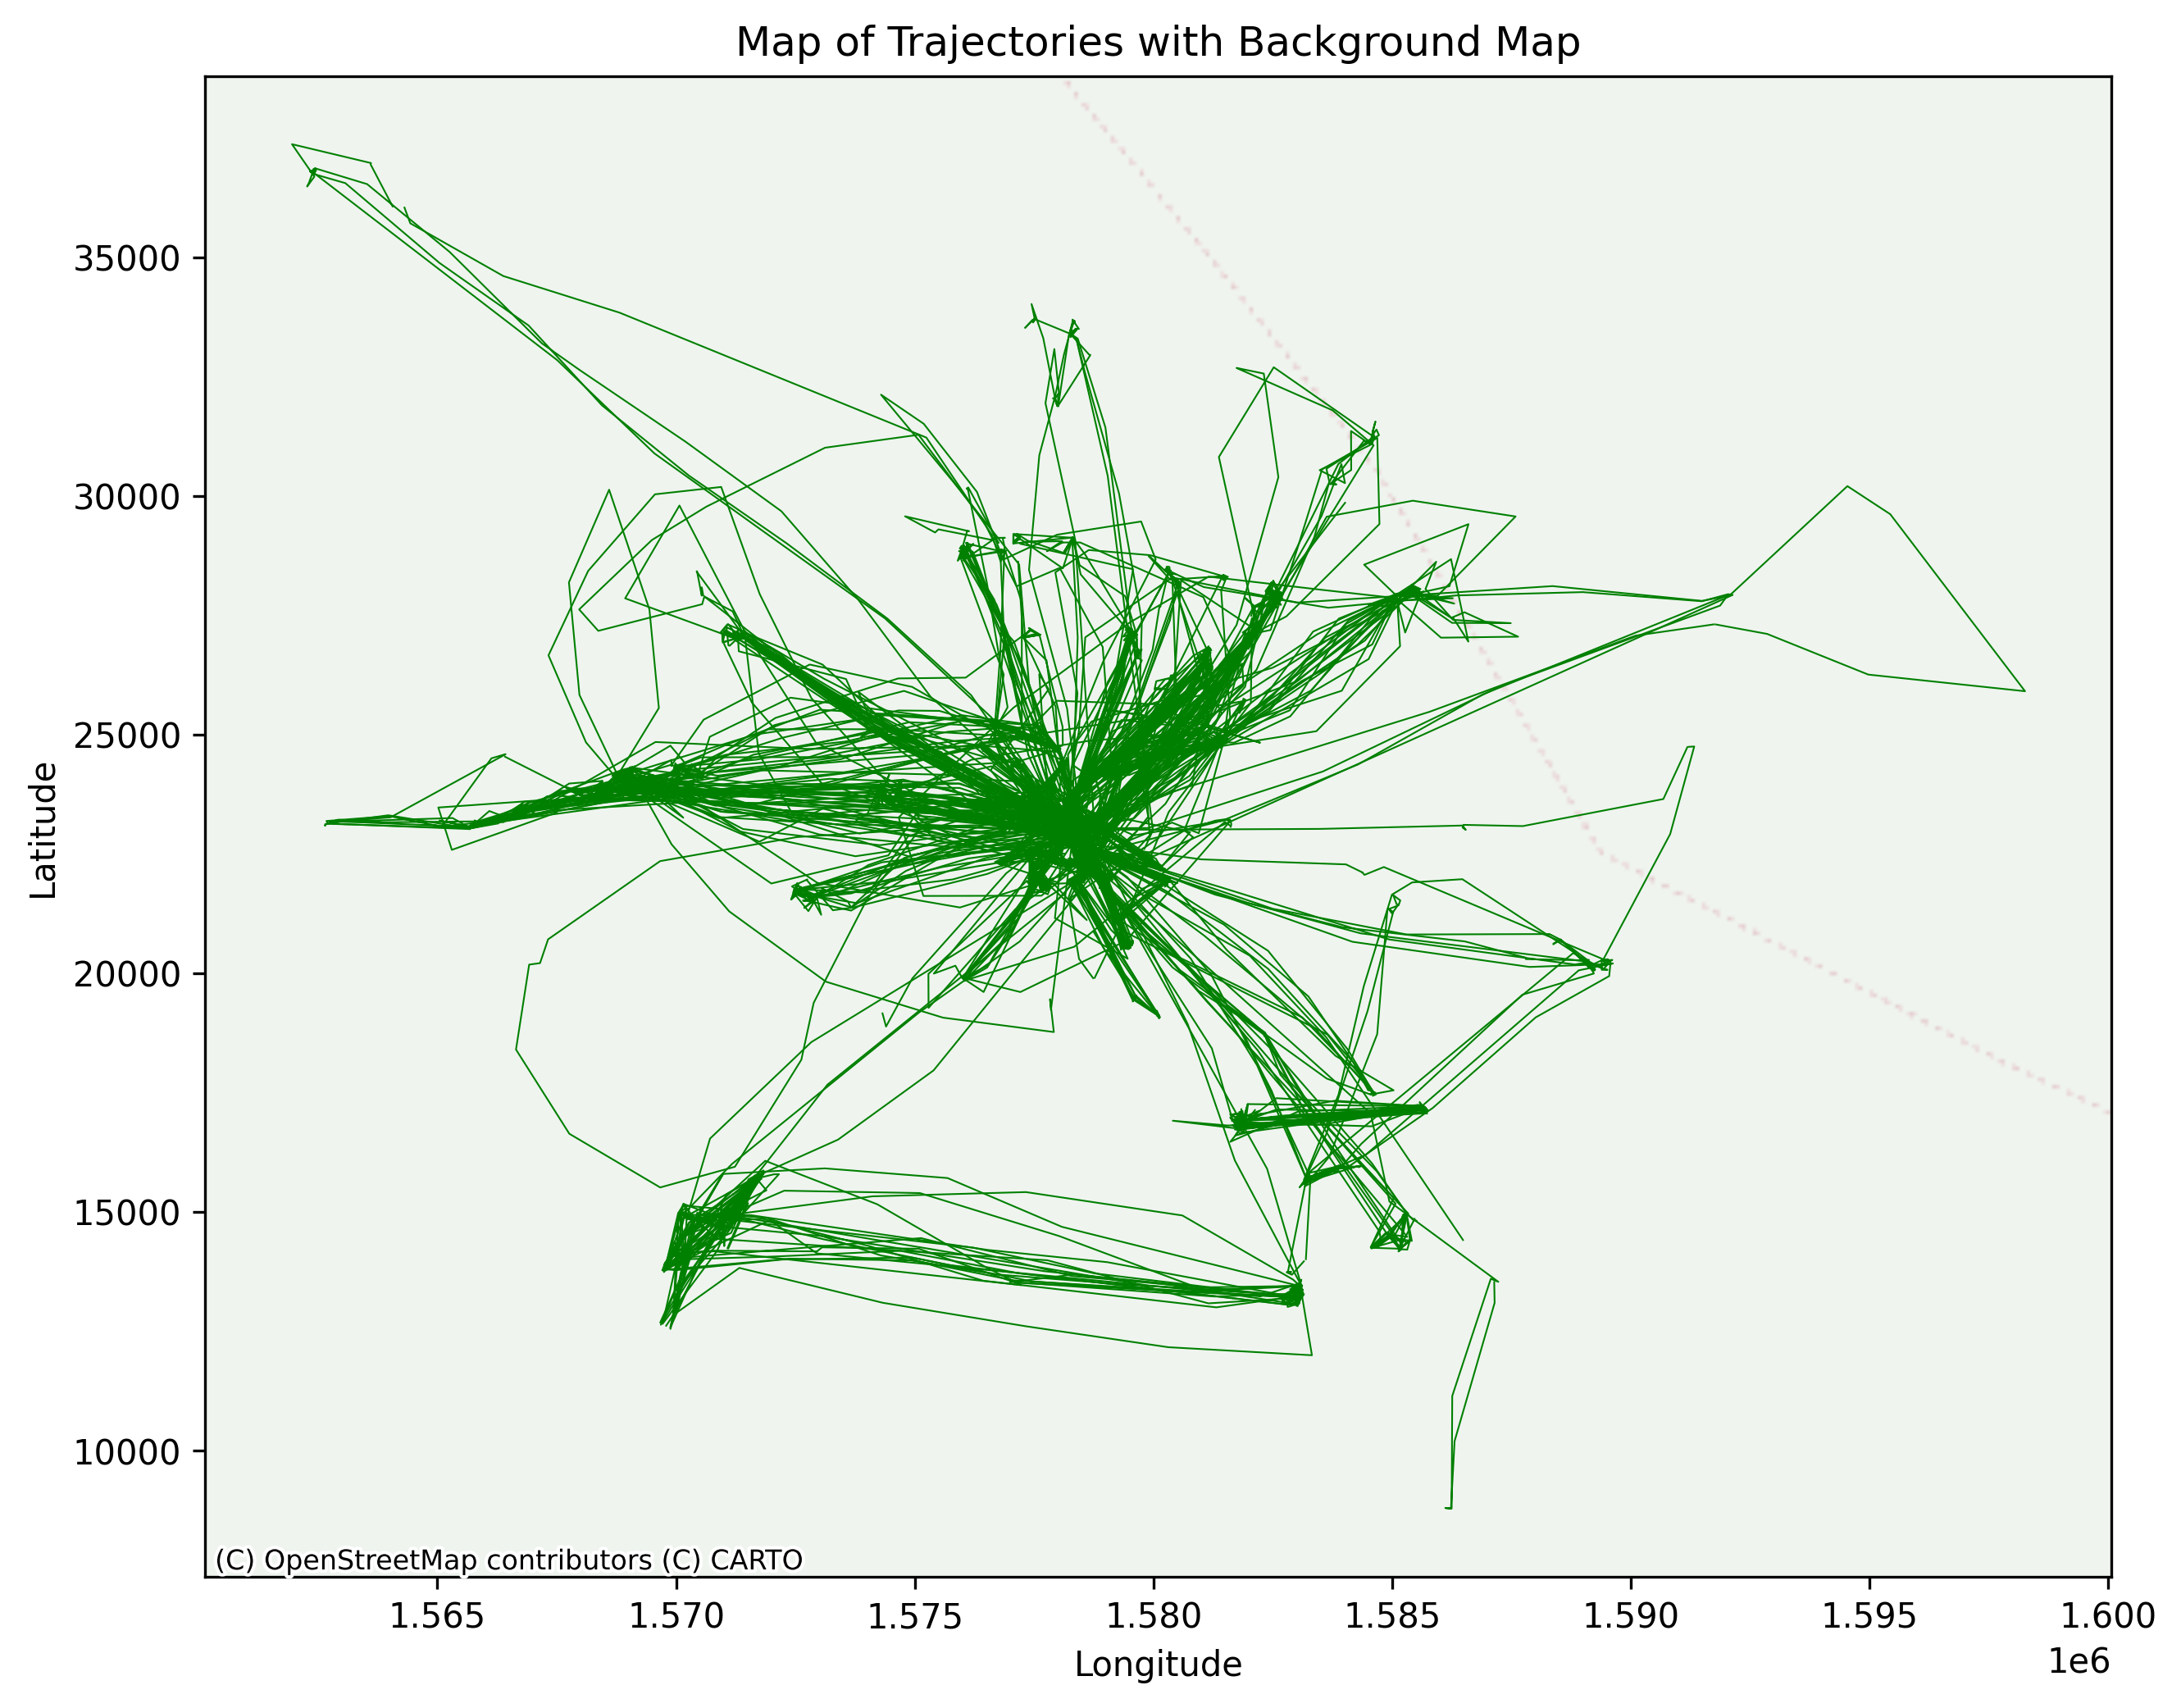

<Figure size 640x480 with 0 Axes>

In [19]:
map_ilustration(gdf, *get_coordinates(gdf))